# Computational Model

In this notebook we have performed and compare the performance of different computational models like 
<br>
1. Negative Binomial Model
2. Poisson Model
3. Gaussian Model
</br>

To use this computational models efficiently, we have designed a **data modelling steps**. 


<br>
</br>
<center>
<img src="https://news2-images.vice.com/uploads/2017/06/trump-math-lady.jpg?crop=1xw:0.8609375xh;center,center&resize=1000:*"/>
</center>

<br>
</br>

## 1. Loading Packages

In [1]:
import os
import pandas as pd
import numpy as np
import pymc3 as pm
import re
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk import FreqDist
import text2emotion as te
from LeXmo import LeXmo
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.formula.api import glm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/meghanshubhatt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/meghanshubhatt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/meghanshubhatt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/meghanshubhatt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('data/data.csv')

In [3]:
df.head()

,Speech,Speech Word Frequency,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,NumWords,SpeechNormalize
0,trump: wow. whoa. that group people. thousands...,<FreqDist with 922 samples and 2793 outcomes>,0.013828,0.033187,0.005992,0.013137,0.026043,0.027887,0.070754,0.014750,0.028578,0.042637,3443,trump wow whoa that group people thousands nic...
1,good evening. thank much speak today lifelong ...,<FreqDist with 608 samples and 1166 outcomes>,0.025760,0.046235,0.011889,0.035667,0.038309,0.044914,0.065390,0.025760,0.032365,0.058124,1273,good evening thank much speak today lifelong s...
2,"thank opportunity speak you, thank center nati...",<FreqDist with 948 samples and 1745 outcomes>,0.016202,0.039154,0.005851,0.027903,0.030603,0.054005,0.076058,0.013951,0.012601,0.055806,1911,thank opportunity speak you thank center natio...
3,thank joining today. this going speech hillary...,<FreqDist with 742 samples and 1539 outcomes>,0.038164,0.023724,0.015988,0.050542,0.013925,0.061888,0.051057,0.030944,0.011862,0.040227,1670,thank joining today this going speech hillary ...
4,today like share thoughts stakes election. peo...,<FreqDist with 877 samples and 1751 outcomes>,0.025103,0.041077,0.011410,0.031949,0.022364,0.052487,0.063441,0.026472,0.016431,0.053400,1891,today like share thoughts stakes election peop...


## 2. Data Modelling for computational model


1. Making a list of most frequent words

2. Creating a Dependent Variable called 'lengthSentence' it's a length of a speech

3. We are predicting the length of speech, using the most frequent words as independent varaiable

4. Made a formula to fit our modelled data, by analyzing distribution of independent varaiables


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

words = []
word_values = []
for i,j in get_top_n_words(df['SpeechNormalize'], 30):
    words.append(i)
    word_values.append(j)

In [5]:
df['lengthSentence'] = df['SpeechNormalize'].apply(len)

In [6]:
def mostFreqWords(i):
    mostFreq = {k:0 for k in words}
    for key, value in mostFreq.items():
        value = df.iloc[i]['SpeechNormalize'].count(key)
        mostFreq[key] = value
    return pd.DataFrame.from_dict(mostFreq,orient='index').T

In [7]:
dataFreq = pd.DataFrame()
for i in range(df.shape[0]):
    dd = mostFreqWords(i)
    dataFreq = pd.concat([dataFreq,dd],axis=0)

dataFreq.reset_index(inplace=True, drop=True)
df = pd.concat([df,dataFreq], axis=1)


In [8]:
col = list(dataFreq.columns.values)
col.append('lengthSentence')

In [9]:
data = df[col]

In [10]:
data.head()

,going,people,country,clinton,hillary,american,jobs,america,know,great,...,states,trade,think,americans,thank,state,united,years,government,lengthSentence
0,44,55,28,1,0,1,14,9,48,41,...,6,9,19,0,10,13,6,7,3,21630
1,8,7,0,1,1,4,0,9,11,7,...,10,0,3,1,10,20,15,5,0,8852
2,7,4,8,7,2,18,6,40,10,7,...,8,9,3,6,3,10,7,1,2,13537
3,5,33,19,19,17,17,0,35,12,3,...,9,0,1,9,2,15,10,2,1,11981
4,13,18,16,50,49,20,15,41,11,12,...,7,7,3,6,1,19,7,4,9,13421


/var/folders/d4/d917y7xs6qs303lp95st4lzr0000gn/T/ipykernel_45236/4230218891.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(bins=5, ax=ax)


array([[<AxesSubplot:title={'center':'going'}>,
        <AxesSubplot:title={'center':'people'}>,
        <AxesSubplot:title={'center':'country'}>,
        <AxesSubplot:title={'center':'clinton'}>,
        <AxesSubplot:title={'center':'hillary'}>,
        <AxesSubplot:title={'center':'american'}>],
       [<AxesSubplot:title={'center':'jobs'}>,
        <AxesSubplot:title={'center':'america'}>,
        <AxesSubplot:title={'center':'know'}>,
        <AxesSubplot:title={'center':'great'}>,
        <AxesSubplot:title={'center':'new'}>,
        <AxesSubplot:title={'center':'said'}>],
       [<AxesSubplot:title={'center':'make'}>,
        <AxesSubplot:title={'center':'want'}>,
        <AxesSubplot:title={'center':'like'}>,
        <AxesSubplot:title={'center':'right'}>,
        <AxesSubplot:title={'center':'trump'}>,
        <AxesSubplot:title={'center':'time'}>],
       [<AxesSubplot:title={'center':'president'}>,
        <AxesSubplot:title={'center':'world'}>,
        <AxesSubplot:title={'c

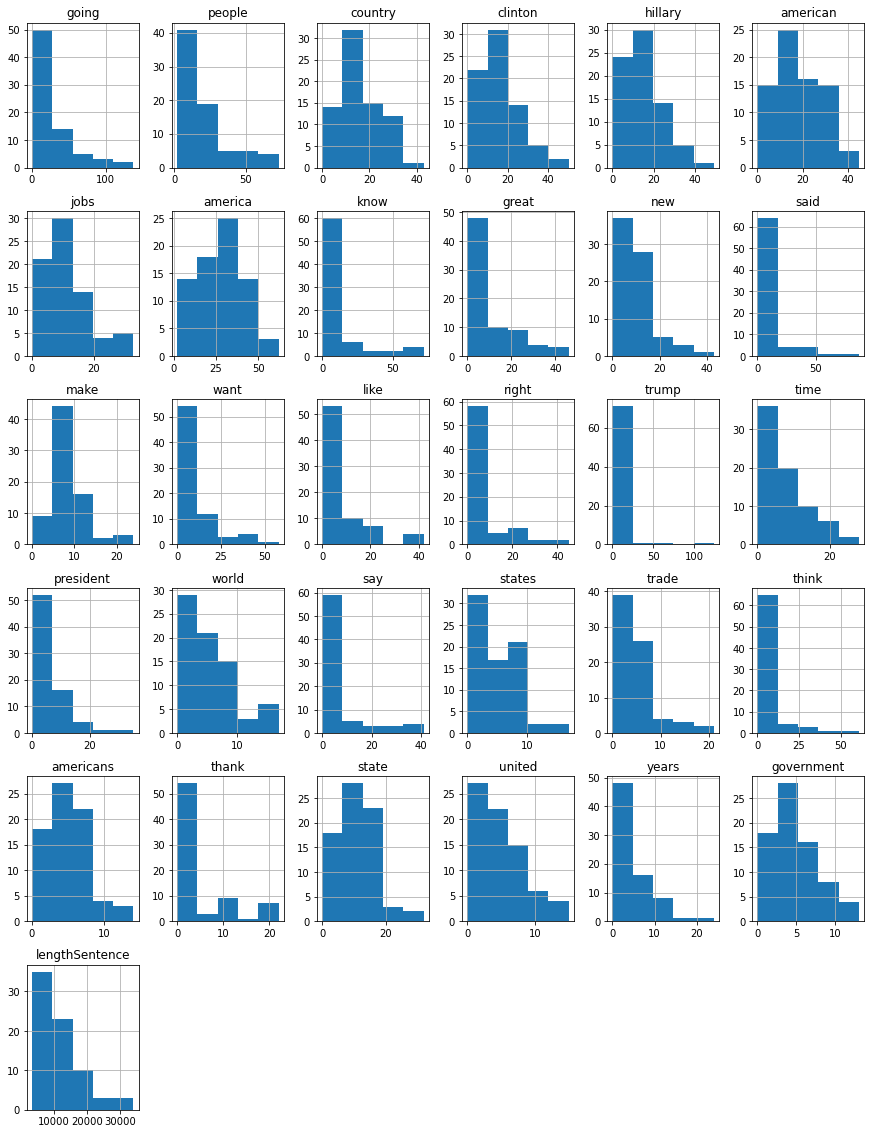

In [11]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.hist(bins=5, ax=ax)


#### patsy formula

1. ':' -> This takes two sets of terms, and computes the interaction between each term on the left and each term on the right. So, for example, (a + b):(c + d) is the same as a:c + a:d + b:c + b:d. Calculating the interaction between two terms is also a kind of set union operation, but : takes the union of factors within two terms, while + takes the union of two sets of terms. Note that this means that a:a is just a, and (a:b):(a:c) is the same as a:b:c.

2. '*' -> a * b is short-hand for a + b + a:b, and is useful for the common case of wanting to include all interactions between a set of variables while partitioning their variance between lower- and higher-order interactions.

In [106]:
## We are predicting length of sentences based on top freq words
formula = "lengthSentence ~ going + trump + time + jobs + new + clinton:hillary + \
           people*country + american:america:americans + president + make:great + \
           united:states + government:state + years + thank:think:say:know:right:like:want:said + trade*world"

In [107]:
mask = np.random.rand(len(data)) < 0.8
df_train = data[mask]
df_test = data[~mask]


In [108]:
import patsy
y_train, X_train = patsy.dmatrices(formula, df_train, return_type = 'dataframe')
y_test, X_test = patsy.dmatrices(formula, df_test, return_type = 'dataframe')

### Negative Binomial

In [15]:
# Regression

nb_training_results = sm.GLM(y_train, X_train, family = sm.families.NegativeBinomial(alpha = 1)).fit()

print(nb_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         lengthSentence   No. Observations:                   63
Model:                            GLM   Df Residuals:                       43
Model Family:        NegativeBinomial   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -643.48
Date:                Mon, 12 Dec 2022   Deviance:                       1.3700
Time:                        23:18:33   Pearson chi2:                     1.40
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1860
Covariance Type:            nonrobust                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

## Use the model to predict y's of the train set

In [16]:
nb_prediction_train = nb_training_results.get_prediction(X_train)

nb_summary_frame_train = nb_prediction_train.summary_frame()

predicted_counts_train = nb_summary_frame_train['mean']
# Accuracy of the train set

print("R-square of train set: ", round(r2_score(y_train, predicted_counts_train)*100, 2), "%")


R-square of train set:  92.51 %


## Use the model to predict y's of the test set

In [17]:
nb_prediction_test = nb_training_results.get_prediction(X_test)

nb_summary_frame_test = nb_prediction_test.summary_frame()

predicted_counts = nb_summary_frame_test['mean']

#Accuracy of the test set

print("R-square of test set: ", round(r2_score(y_test, predicted_counts)*100, 2), "%")

R-square of test set:  73.07 %


## Plot predited y's versus actual y's of the test set

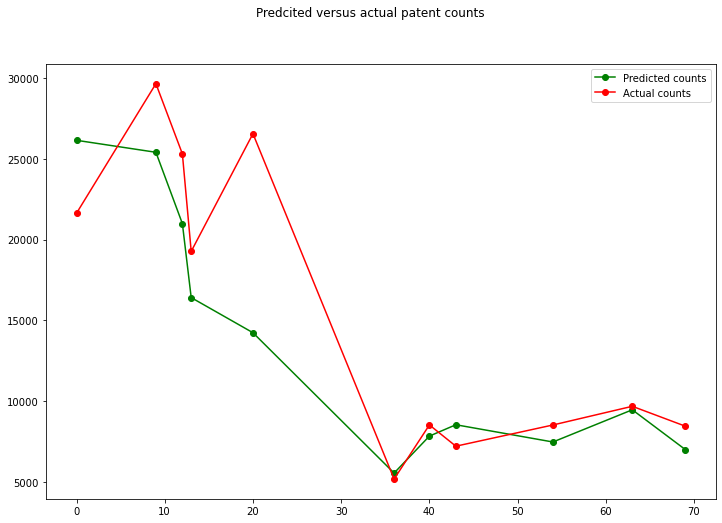

In [18]:
fig = plt.figure(figsize = (12, 8))

fig.suptitle('Predcited versus actual patent counts')

predicted, = plt.plot(X_test.index, predicted_counts , 'go-', label = 'Predicted counts')
actual, = plt.plot(X_test.index, y_test['lengthSentence'] , 'ro-', label = 'Actual counts')


plt.legend(handles = [predicted, actual])
plt.show()


## Poisson

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [20]:
nb_training_results = sm.GLM(y_train, X_train, family = sm.families.Poisson()).fit()

print(nb_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         lengthSentence   No. Observations:                   63
Model:                            GLM   Df Residuals:                       43
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6653.8
Date:                Mon, 12 Dec 2022   Deviance:                       12612.
Time:                        23:18:45   Pearson chi2:                 1.28e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

## Use the model to predict y's of the train set

In [21]:
nb_prediction_train = nb_training_results.get_prediction(X_train)

nb_summary_frame_train = nb_prediction_train.summary_frame()

predicted_counts_train = nb_summary_frame_train['mean']
# Accuracy of the train set

print("R-square of train set: ", round(r2_score(y_train, predicted_counts_train)*100, 2), "%")


R-square of train set:  93.98 %


## Use the model to predict y's of the test set

In [22]:
nb_prediction_test = nb_training_results.get_prediction(X_test)

nb_summary_frame_test = nb_prediction_test.summary_frame()

predicted_counts = nb_summary_frame_test['mean']

#Accuracy of the test set

print("R-square of test set: ", round(r2_score(y_test, predicted_counts)*100, 2), "%")

R-square of test set:  61.41 %


## Plot predited y's versus actual y's of the test set

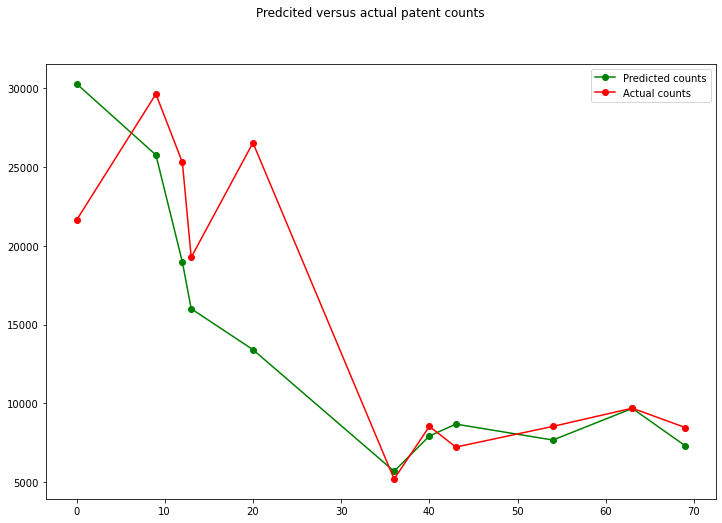

In [23]:
fig = plt.figure(figsize = (12, 8))

fig.suptitle('Predcited versus actual patent counts')

predicted, = plt.plot(X_test.index, predicted_counts , 'go-', label = 'Predicted counts')
actual, = plt.plot(X_test.index, y_test['lengthSentence'] , 'ro-', label = 'Actual counts')


plt.legend(handles = [predicted, actual])
plt.show()


### Gaussaian

In [109]:
nb_training_results = sm.GLM(y_train, X_train, family = sm.families.Gaussian()).fit()

print(nb_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         lengthSentence   No. Observations:                   63
Model:                            GLM   Df Residuals:                       43
Model Family:                Gaussian   Df Model:                           19
Link Function:               identity   Scale:                      2.5704e+06
Method:                          IRLS   Log-Likelihood:                -542.29
Date:                Mon, 12 Dec 2022   Deviance:                   1.1053e+08
Time:                        23:23:11   Pearson chi2:                 1.11e+08
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

### Use the model to predict y's of the train set

In [110]:
nb_prediction_train = nb_training_results.get_prediction(X_train)

nb_summary_frame_train = nb_prediction_train.summary_frame()

predicted_counts_train = nb_summary_frame_train['mean']
# Accuracy of the train set

print("R-square of train set: ", round(r2_score(y_train, predicted_counts_train)*100, 2), "%")


R-square of train set:  95.79 %


### Use the model to predict y's of the test set

In [111]:
nb_prediction_test = nb_training_results.get_prediction(X_test)

nb_summary_frame_test = nb_prediction_test.summary_frame()

predicted_counts = nb_summary_frame_test['mean']

#Accuracy of the test set

print("R-square of test set: ", round(r2_score(y_test, predicted_counts)*100, 2), "%")

R-square of test set:  91.37 %


### Plot predited y's versus actual y's of the test set

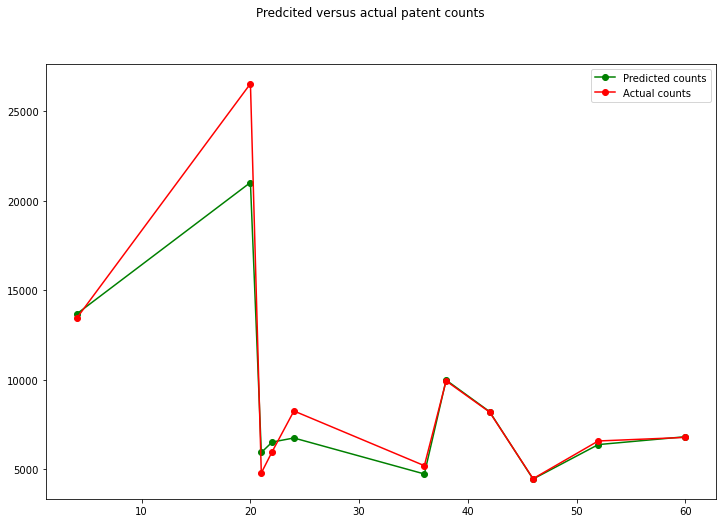

In [112]:
fig = plt.figure(figsize = (12, 8))

fig.suptitle('Predcited versus actual patent counts')

predicted, = plt.plot(X_test.index, predicted_counts , 'go-', label = 'Predicted counts')
actual, = plt.plot(X_test.index, y_test['lengthSentence'] , 'ro-', label = 'Actual counts')


plt.legend(handles = [predicted, actual])
plt.show()


## The End

<br>
</br>
<center>
<img src="meme.jpeg" width="400" 
     height="500"/>
</center>

<br>
</br>
